#**AI ANIME RECOMMENDATION SYSTEM USING TF-IDF + Cosine Similarity**

#STEP 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

#STEP 2: Upload the Dataset (anime.csv from Kaggle)

In [2]:
from google.colab import files
uploaded = files.upload()

Saving anime.csv to anime.csv


#STEP 3: Load & Preprocess the Dataset

In [3]:
anime_df = pd.read_csv("anime.csv")
# Drop rows with missing genres
anime_df = anime_df.dropna(subset=['genre'])

# Clean and format genres
anime_df['genre'] = anime_df['genre'].str.replace(", ", ",")  # remove space after commas
anime_df['genre'] = anime_df['genre'].str.lower()  # convert to lowercase

# Fill missing anime names
anime_df['name'] = anime_df['name'].fillna("Unknown")

# Use only useful columns
anime_df = anime_df[['name', 'genre', 'type', 'rating']]

#STEP 4: TF-IDF Vectorization on Genre Field

In [4]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(anime_df['genre'])

#STEP 5: Compute Cosine Similarity

In [5]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

#STEP 6: Build Name-to-Index Mapping

In [6]:
indices = pd.Series(anime_df.index, index=anime_df['name']).drop_duplicates()

#STEP 7: Recommendation Function

In [7]:
def recommend_anime(title, top_n=5):
    if title not in indices:
        return pd.DataFrame([{"Error": "Anime not found in dataset."}])

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    anime_indices = [i[0] for i in sim_scores]

    return anime_df[['name', 'genre', 'rating']].iloc[anime_indices]

#STEP 8: Test a Single Recommendation

In [8]:
title = "Death Note"
recommendations = recommend_anime(title)
print(f"Top recommendations for '{title}':")
print(recommendations)

Top recommendations for 'Death Note':
                               name  \
778              Death Note Rewrite   
981                 Mousou Dairinin   
144   Higurashi no Naku Koro ni Kai   
1383  Higurashi no Naku Koro ni Rei   
445                Mirai Nikki (TV)   

                                                  genre  rating  
778   mystery,police,psychological,supernatural,thri...    7.84  
981   drama,mystery,police,psychological,supernatura...    7.74  
144         mystery,psychological,supernatural,thriller    8.41  
1383  comedy,mystery,psychological,supernatural,thri...    7.56  
445   action,mystery,psychological,shounen,supernatu...    8.07  


#STEP 9: Precision@K Evaluation Function

In [9]:
def precision_at_k(title, k=5):
    if title not in indices:
        print(f"'{title}' not found in dataset.")
        return 0.0

    idx = indices[title]
    input_genres = set(anime_df['genre'].iloc[idx].split(','))

    recommended = recommend_anime(title, top_n=k)
    match_count = 0

    for _, row in recommended.iterrows():
        rec_genres = set(str(row['genre']).split(','))
        if input_genres & rec_genres:
            match_count += 1

    return match_count / k

#STEP 10: Evaluate on Popular Test Titles

In [ ]:
test_titles = [
    "Death Note",
    "Naruto",
    "One Piece",
    "Shingeki no Kyojin",  # Attack on Titan
    "Sword Art Online",
    "Fullmetal Alchemist: Brotherhood",
    "Tokyo Ghoul",
    "Bleach",
    "Steins;Gate",
    "Kimi no Na wa."  # Your Name
]

precisions = []
for t in test_titles:
    p = precision_at_k(t, k=5)
    precisions.append(p)
    print(f"Precision@5 for '{t}': {p:.2f}")

avg_precision = np.mean(precisions)
print(f"\nAverage Precision@5: {avg_precision*100:.2f}%")

Precision@5 for 'Death Note': 1.00
Precision@5 for 'Naruto': 1.00
Precision@5 for 'One Piece': 1.00
Precision@5 for 'Shingeki no Kyojin': 1.00
Precision@5 for 'Sword Art Online': 1.00
Precision@5 for 'Fullmetal Alchemist: Brotherhood': 1.00
Precision@5 for 'Tokyo Ghoul': 1.00
Precision@5 for 'Bleach': 1.00
Precision@5 for 'Steins;Gate': 1.00
Precision@5 for 'Kimi no Na wa.': 1.00

Average Precision@5: 100.00%


#STEP 11: Visualize Results

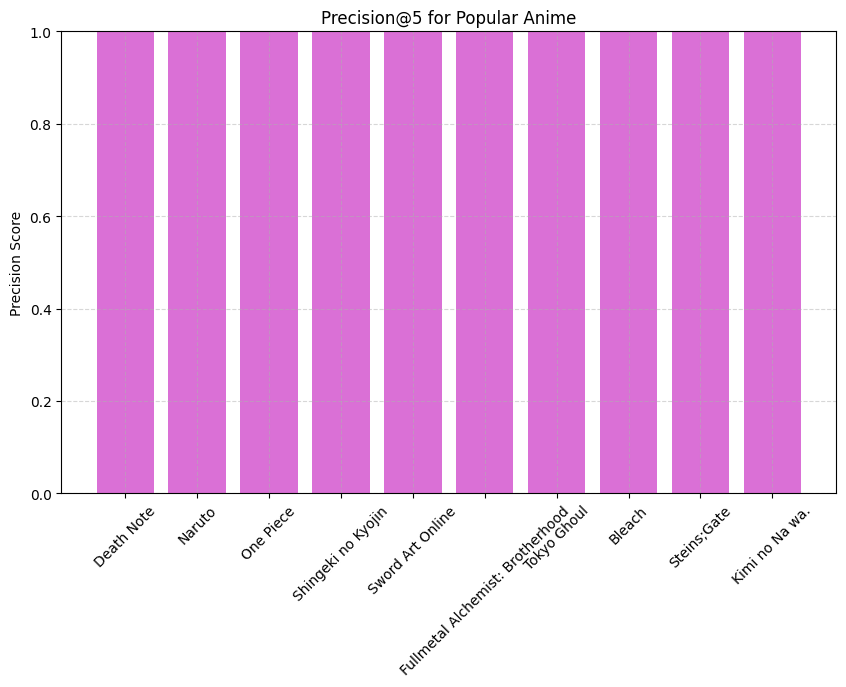

In [11]:
plt.figure(figsize=(10,6))
plt.bar(test_titles, precisions, color='orchid')
plt.title("Precision@5 for Popular Anime")
plt.ylabel("Precision Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()